In [1]:
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, silhouette_samples, silhouette_score, roc_curve, roc_auc_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

%matplotlib inline 
warnings.filterwarnings('ignore')

train_raw = pd.read_csv('train.csv')
train_raw.head()

,ID,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,...,Job Code,Job,Employee Identifier,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,9248,Fiscal,2017,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2905,Senior Eligibility Worker,41351,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,44541,Fiscal,2014,6,General Administration & Finance,ASR,ASR Assessor / Recorder,21,"Prof & Tech Engineers - Miscellaneous, Local 21",4200,...,4222,Sr Personal Property Auditor,41792,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,47031,Fiscal,2014,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2910,Social Worker,9357,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,139416,Fiscal,2014,1,Public Protection,FIR,FIR Fire Department,798,"Firefighters - Miscellaneous, Local 798",H000,...,H002,Firefighter,28022,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,123780,Fiscal,2013,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,790,"SEIU - Miscellaneous, Local 1021",1600,...,1224,Pr Payroll & Personnel Clerk,51052,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


In [2]:
%matplotlib inline 
warnings.filterwarnings('ignore')

In [3]:
def handle_negative_values(dataset,feature):
    dataset[feature] = dataset[feature].abs()

In [4]:
def drop_features(dataset, features):
    dataset.drop(columns=features, inplace=True)

In [5]:
def get_encoder(encoder_type='one hot'):
    if encoder_type == 'one hot':
        return OneHotEncoder(drop='first', # to return k-1, use drop=false to return k dummies
                            sparse=True)
    elif encoder_type == 'label':
        return LabelEncoder()

In [6]:
def encode_variable(dataset, feature, strategy):
    print('Unique values count before encoding: ')
    print(dataset[feature].nunique())
    encoder = get_encoder(strategy)
    if strategy == 'one hot':
        temp = pd.DataFrame(dataset[feature], columns=[feature])
        dataset[feature] = encoder.fit_transform(temp)
    else:
        dataset[feature] = encoder.fit_transform(dataset[feature])
    return dataset

In [7]:
def scale_variable(dataset):
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset = pd.DataFrame(scaler.transform(dataset), columns=dataset.columns)
    return dataset

In [8]:
def outlier_analysis_plot(dataset, variable, plot_name):
    plt.figure(figsize=(15, 15))
    dataset[variable].boxplot()
    plt.title(plot_name)
    plt.show()

In [9]:
def skewness_analysis_plot(dataset):
    for col in dataset.columns:
        print('Skewness measure of ', col, ': ', stats.skew(dataset[col]))
    dataset.hist(bins=10, figsize=(10,10))

In [10]:
def distribution_analysis_plot(dataset, feature, plot_name):
    print('Skewness measure of ', feature, ': ', stats.skew(dataset[feature]))
    
    plt.figure(figsize=(15,6))
    #plot histogram
    plt.subplot(1, 2, 1)
    dataset[feature].hist(bins=30)
    #plot qq plot
    plt.subplot(1, 2, 2)
    stats.probplot(dataset[feature], dist="norm", plot=plt)
    
    plt.title(plot_name)
    plt.show()

In [11]:
def transform_variable(dataset, feature, strategy, a):
    temp_dataset = dataset
    if strategy == 'log':
        #build the transformer
        transformer = FunctionTransformer(np.log1p, validate=True)
    else:
        #get the best exponential value
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(pd.DataFrame(temp_dataset[feature], columns=[feature]))
        print('The best exponential value: ', pt.lambdas_.item(0))
        #build the transformer
        temp_dataset[feature] = temp_dataset[feature] + a #avoid issues related to negative values leading to inf
        transformer = FunctionTransformer(lambda x: x**(pt.lambdas_.item(0)), validate=True)
    #perform transformation
    temp_dataset[feature] = transformer.fit_transform(pd.DataFrame(temp_dataset[feature], columns=[feature]))
    return temp_dataset

In [36]:
def line_chart_plot(data, xlabel, ylabel, x_lowerlim, x_upperlim, plot_name):
    plt.figure(figsize=(10,10))
    plt.plot(data, 'bx-')
    plt.xlim(x_lowerlim, x_upperlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(plot_name)
    plt.grid(True)
    plt.show()

In [43]:
def optimal_cluster_analysis_plot(X, n_clusters, cluster_labels):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    # 1st plot - silhoutte analysis
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot - showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200)
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [12]:
train_raw = pd.read_csv('train.csv')
train_raw.head()

,ID,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,...,Job Code,Job,Employee Identifier,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,9248,Fiscal,2017,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2905,Senior Eligibility Worker,41351,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,44541,Fiscal,2014,6,General Administration & Finance,ASR,ASR Assessor / Recorder,21,"Prof & Tech Engineers - Miscellaneous, Local 21",4200,...,4222,Sr Personal Property Auditor,41792,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,47031,Fiscal,2014,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2910,Social Worker,9357,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,139416,Fiscal,2014,1,Public Protection,FIR,FIR Fire Department,798,"Firefighters - Miscellaneous, Local 798",H000,...,H002,Firefighter,28022,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,123780,Fiscal,2013,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,790,"SEIU - Miscellaneous, Local 1021",1600,...,1224,Pr Payroll & Personnel Clerk,51052,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


In [13]:
numerical_cols = list(train_raw.select_dtypes([np.int64, np.float64]).columns)
print('Numerical columns in the dataset: ', numerical_cols)

Numerical columns in the dataset:  ['ID', 'Year', 'Organization Group Code', 'Union Code', 'Employee Identifier', 'Overtime', 'Other Salaries', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits', 'Class']


In [14]:
categorical_cols = list(train_raw.select_dtypes(['object']).columns)
print('Categorical columns in the dataset: ', categorical_cols)

Categorical columns in the dataset:  ['Year Type', 'Organization Group', 'Department Code', 'Department', 'Union', 'Job Family Code', 'Job Family', 'Job Code', 'Job']


In [15]:
X = train_raw.drop(['Year Type', 'Organization Group', 'Department', 'Union', 'Job Family', 'Job', 'Employee Identifier', 'Year', 'Class'], axis=1)
y = train_raw['Class']

In [16]:
X.set_index('ID',inplace=True)

In [17]:
size = 0.3
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

In [18]:
features_with_neg_value = ['Overtime', 'Other Salaries', 'Retirement', 'Health/Dental', 'Other Benefits', 'Total Benefits']
for feature in features_with_neg_value:
     handle_negative_values(X_train,feature)

In [19]:
features_to_encode = ['Department Code', 'Job Family Code', 'Job Code']
for feature in features_to_encode:
    encode_variable(X_train, feature, 'label')

Unique values count before encoding: 
56
Unique values count before encoding: 
61
Unique values count before encoding: 
1117


In [20]:
X_train.head()

,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits
ID,,,,,,,,,,,
101776,6,32,790,41,825,0.00,10709.02,0.00,0.00,819.24,819.24
212979,2,55,21,13,279,0.00,6480.08,16810.74,12877.49,8064.13,37752.36
124984,1,41,911,56,1104,2814.44,6941.88,15253.66,9251.07,1541.72,26046.45
62824,2,37,253,47,973,13121.61,5145.59,17124.80,11162.42,5624.56,33911.78
79314,2,17,39,37,691,0.00,0.00,21180.93,13765.55,9692.16,44638.64


In [21]:
X_train = scale_variable(X_train)
X_train.head()

,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits
0,1.912845,0.299542,0.894928,0.625216,0.552853,-0.397601,0.930491,-1.313933,-1.808622,-0.996286,-1.521136
1,-0.616072,2.031426,-1.408139,-0.937880,-0.961031,-0.397601,0.364152,0.428823,0.757331,0.853333,0.669103
2,-1.248301,0.977236,1.257309,1.462588,1.326431,-0.151479,0.425996,0.267402,0.034735,-0.811837,-0.025091
3,-0.616072,0.676038,-0.713326,0.960165,0.963210,0.749881,0.185437,0.461381,0.415588,0.230512,0.441346
4,-0.616072,-0.829947,-1.354231,0.401916,0.181313,-0.397601,-0.503660,0.881877,0.934284,1.268969,1.077479


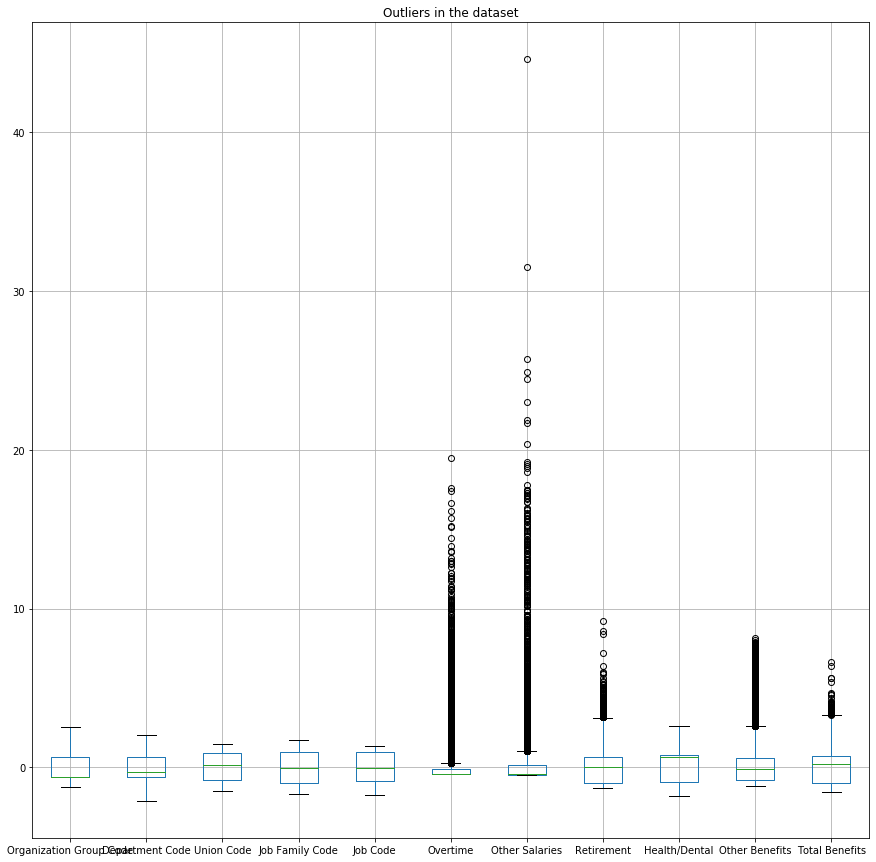

In [22]:
outlier_analysis_plot(X_train, list(X_train.columns), 'Outliers in the dataset')

Skewness measure of  Organization Group Code :  0.45721740167687874
Skewness measure of  Department Code :  -0.11621376173234123
Skewness measure of  Union Code :  -0.2605432867202852
Skewness measure of  Job Family Code :  -0.032184687132809094
Skewness measure of  Job Code :  -0.07753553674468014
Skewness measure of  Overtime :  4.460736431630667
Skewness measure of  Other Salaries :  6.9393028678423
Skewness measure of  Retirement :  0.45189529288401104
Skewness measure of  Health/Dental :  -0.6905179248480019
Skewness measure of  Other Benefits :  1.6088317442323479
Skewness measure of  Total Benefits :  -0.045815006434587385


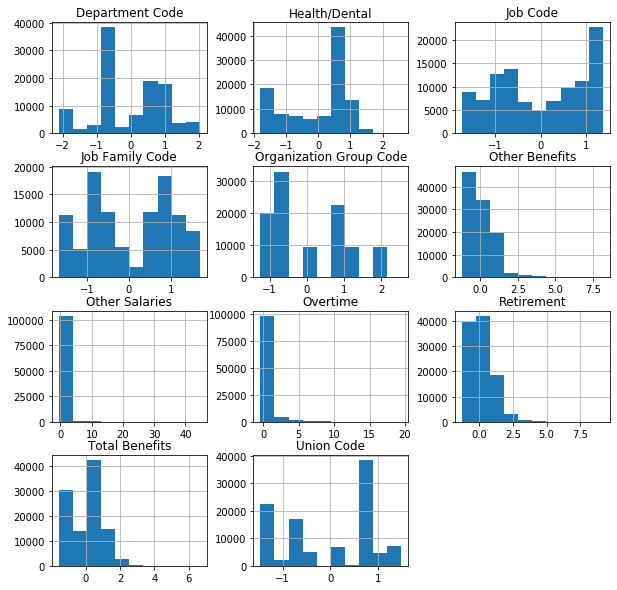

In [23]:
skewness_analysis_plot(X_train)

Skewness measure of  Overtime :  4.460736431630667


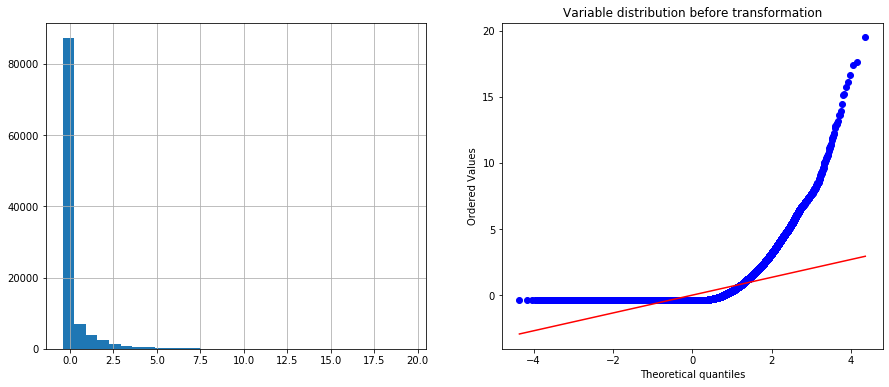

In [24]:
distribution_analysis_plot(X_train, 'Overtime', 'Variable distribution before transformation')

In [25]:
transform_variable(X_train, 'Overtime', 'exp', 1)
#transform_variable(X_train, 'Overtime', 'log', 1)

The best exponential value:  -2.56283516944957


,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits
0,1.912845,0.299542,0.894928,0.625216,0.552853,3.665384,0.930491,-1.313933,-1.808622,-0.996286,-1.521136
1,-0.616072,2.031426,-1.408139,-0.937880,-0.961031,3.665384,0.364152,0.428823,0.757331,0.853333,0.669103
2,-1.248301,0.977236,1.257309,1.462588,1.326431,1.523440,0.425996,0.267402,0.034735,-0.811837,-0.025091
3,-0.616072,0.676038,-0.713326,0.960165,0.963210,0.238347,0.185437,0.461381,0.415588,0.230512,0.441346
4,-0.616072,-0.829947,-1.354231,0.401916,0.181313,3.665384,-0.503660,0.881877,0.934284,1.268969,1.077479
5,-0.616072,1.127834,0.894928,-1.440303,-1.390797,3.443042,-0.503660,0.202884,0.816805,0.382581,0.448208
6,-1.248301,0.977236,1.257309,1.462588,1.354158,0.223456,0.442491,1.606074,0.923771,-0.425681,1.094974
7,0.648386,-0.604050,-0.722310,-0.993704,-1.069166,0.723721,0.592215,0.445928,0.682401,0.485068,0.571044
8,1.912845,-1.582940,0.894928,-1.440303,-1.471205,3.665384,-0.503660,-0.201894,0.138385,-0.344684,-0.154185
9,0.648386,-0.604050,-0.722310,-0.993704,-1.058075,0.362800,0.176251,0.133184,0.684250,0.351950,0.361771


Skewness measure of  Overtime :  -0.9808180627185148


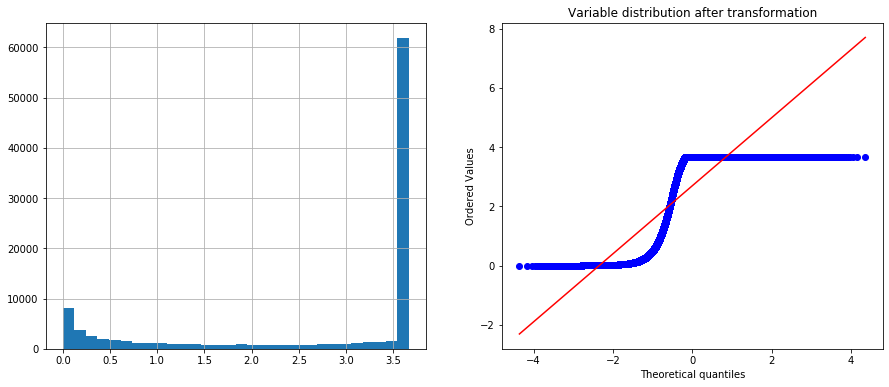

In [26]:
distribution_analysis_plot(X_train, 'Overtime', 'Variable distribution after transformation')

Skewness measure of  Other Salaries :  6.9393028678423


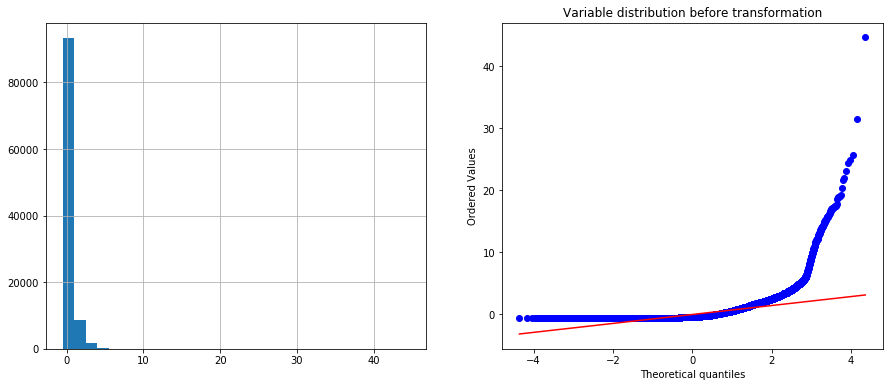

In [27]:
distribution_analysis_plot(X_train, 'Other Salaries', 'Variable distribution before transformation')

In [28]:
transform_variable(X_train, 'Other Salaries', 'log', 1)
transform_variable(X_train, 'Other Salaries', 'log', 1)

,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits
0,1.912845,0.299542,0.894928,0.625216,0.552853,3.665384,0.505476,-1.313933,-1.808622,-0.996286,-1.521136
1,-0.616072,2.031426,-1.408139,-0.937880,-0.961031,3.665384,0.270434,0.428823,0.757331,0.853333,0.669103
2,-1.248301,0.977236,1.257309,1.462588,1.326431,1.523440,0.303706,0.267402,0.034735,-0.811837,-0.025091
3,-0.616072,0.676038,-0.713326,0.960165,0.963210,0.238347,0.157099,0.461381,0.415588,0.230512,0.441346
4,-0.616072,-0.829947,-1.354231,0.401916,0.181313,3.665384,-1.205620,0.881877,0.934284,1.268969,1.077479
5,-0.616072,1.127834,0.894928,-1.440303,-1.390797,3.443042,-1.205620,0.202884,0.816805,0.382581,0.448208
6,-1.248301,0.977236,1.257309,1.462588,1.354158,0.223456,0.312159,1.606074,0.923771,-0.425681,1.094974
7,0.648386,-0.604050,-0.722310,-0.993704,-1.069166,0.723721,0.381941,0.445928,0.682401,0.485068,0.571044
8,1.912845,-1.582940,0.894928,-1.440303,-1.471205,3.665384,-1.205620,-0.201894,0.138385,-0.344684,-0.154185
9,0.648386,-0.604050,-0.722310,-0.993704,-1.058075,0.362800,0.150429,0.133184,0.684250,0.351950,0.361771


Skewness measure of  Other Salaries :  0.5667632366483965


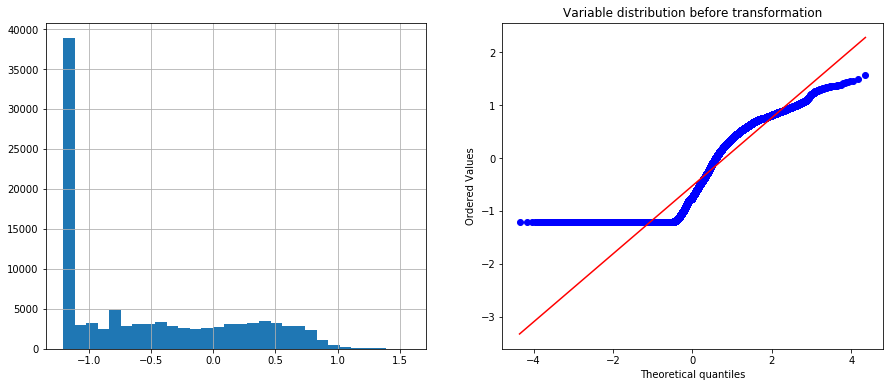

In [29]:
distribution_analysis_plot(X_train, 'Other Salaries', 'Variable distribution before transformation')

Skewness measure of  Other Benefits :  1.6088317442323479


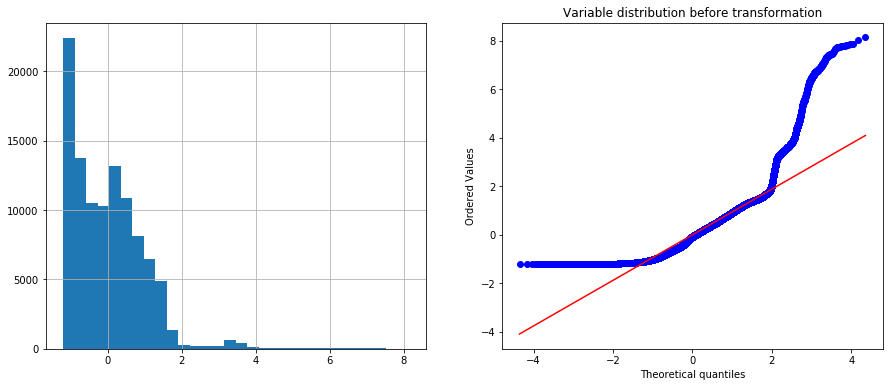

In [30]:
distribution_analysis_plot(X_train, 'Other Benefits', 'Variable distribution before transformation')

In [31]:
transform_variable(X_train, 'Other Benefits', 'exp', 10)
transform_variable(X_train, 'Other Benefits', 'exp', 10)

The best exponential value:  0.35257414005673543
The best exponential value:  -14.12349943601931


,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits
0,1.912845,0.299542,0.894928,0.625216,0.552853,3.665384,0.505476,-1.313933,-1.808622,4.696633e-16,-1.521136
1,-0.616072,2.031426,-1.408139,-0.937880,-0.961031,3.665384,0.270434,0.428823,0.757331,3.960571e-16,0.669103
2,-1.248301,0.977236,1.257309,1.462588,1.326431,1.523440,0.303706,0.267402,0.034735,4.612573e-16,-0.025091
3,-0.616072,0.676038,-0.713326,0.960165,0.963210,0.238347,0.157099,0.461381,0.415588,4.184134e-16,0.441346
4,-0.616072,-0.829947,-1.354231,0.401916,0.181313,3.665384,-1.205620,0.881877,0.934284,3.822800e-16,1.077479
5,-0.616072,1.127834,0.894928,-1.440303,-1.390797,3.443042,-1.205620,0.202884,0.816805,4.127521e-16,0.448208
6,-1.248301,0.977236,1.257309,1.462588,1.354158,0.223456,0.312159,1.606074,0.923771,4.445065e-16,1.094974
7,0.648386,-0.604050,-0.722310,-0.993704,-1.069166,0.723721,0.381941,0.445928,0.682401,4.090127e-16,0.571044
8,1.912845,-1.582940,0.894928,-1.440303,-1.471205,3.665384,-1.205620,-0.201894,0.138385,4.411306e-16,-0.154185
9,0.648386,-0.604050,-0.722310,-0.993704,-1.058075,0.362800,0.150429,0.133184,0.684250,4.138815e-16,0.361771


Skewness measure of  Other Benefits :  -0.7559375155201087


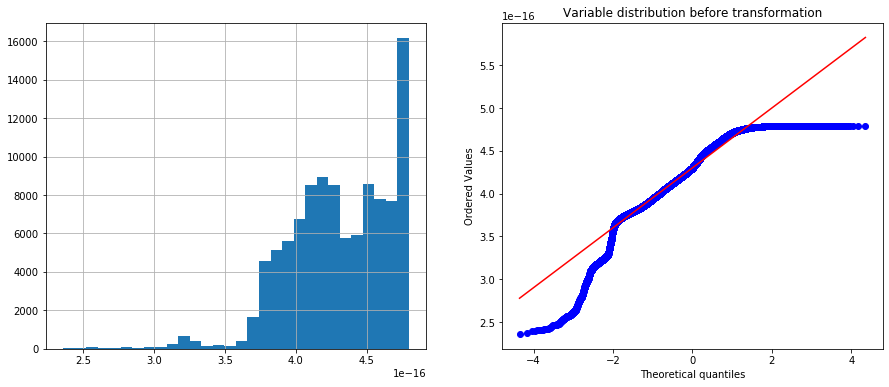

In [32]:
distribution_analysis_plot(X_train, 'Other Benefits', 'Variable distribution before transformation')

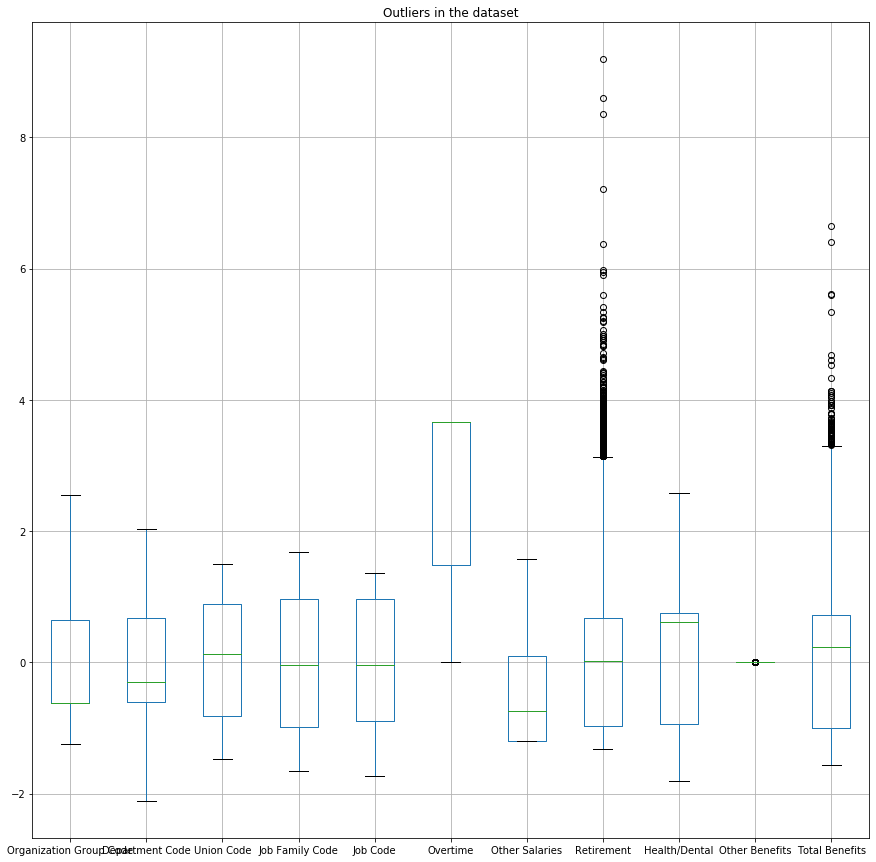

In [33]:
outlier_analysis_plot(X_train, list(X_train.columns), 'Outliers in the dataset')

PCA

In [34]:
X_train_pca = X_train

pca = PCA()
X_train_pca = pca.fit(X_train_pca)
pca.explained_variance_ratio_

array([0.38206882, 0.22444022, 0.10517752, 0.09311119, 0.08134983,
       0.05632981, 0.02666519, 0.01745834, 0.01209871, 0.00130038,
       0.        ])

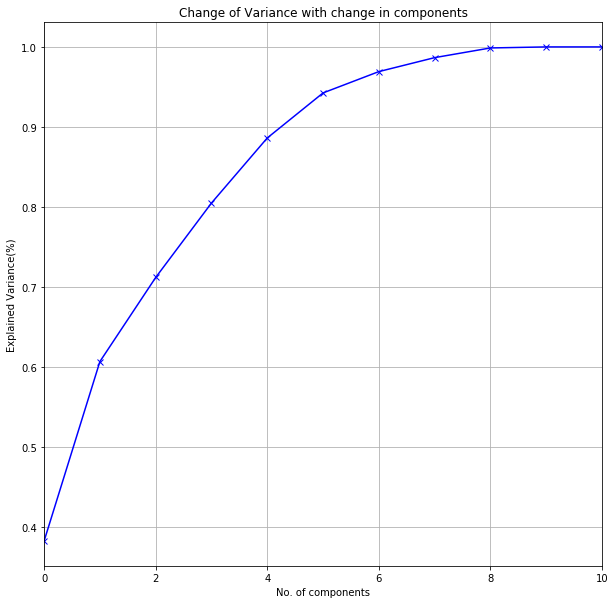

In [38]:
line_chart_plot(np.cumsum(pca.explained_variance_ratio_), 
                'No. of components', 'Explained Variance(%)',
                0, 10,
                'Change of Variance with change in components')

In [39]:
X_train_pca = X_train

pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_pca)

In [41]:
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df.head()

,0,1,2,3,4,5,6,7
0,-2.186742,-1.939983,0.735549,0.743559,-0.099209,1.572082,1.356935,-0.549324
1,0.252055,1.313203,-0.490948,-1.373524,2.263640,-0.674830,0.924719,-0.826968
2,2.188207,-2.027145,0.203669,0.916854,0.463445,-0.225653,0.249067,-0.060162
3,2.780750,-0.923643,0.419844,-1.132115,-0.371382,0.285685,0.146132,0.053416
4,0.580806,1.342502,-2.183659,-0.258593,-0.322170,-0.140421,-0.447455,0.060187


For n_clusters = 2 The average silhouette_score is : 0.27674484725677


KeyboardInterrupt: 

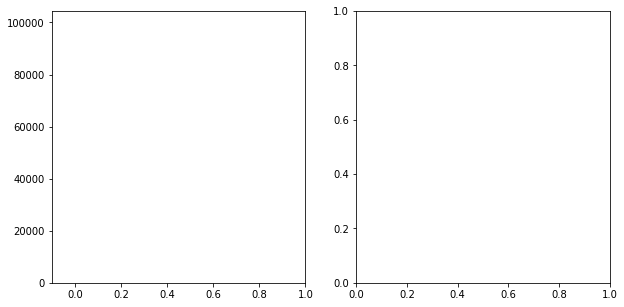

In [44]:
#Get optimal clusters for K-Means cluster analysis
wcss = []
for cluster in range(2,3):
    clusterer = KMeans(n_clusters=cluster,init='k-means++', n_init=10, max_iter=300, random_state=0)
    cluster_labels = clusterer.fit_predict(X_train_pca)
    # using the silhoutte process to find the optimal number of clusters.
    optimal_cluster_analysis_plot(X_train_pca, cluster, cluster_labels)
    wcss.append(clusterer.inertia_)

# also using the elbow method process to find the optimal number of clusters.
print(wcss)
line_chart_plot(wcss, 'No. of clusters', 'WCSS', 2, 10, 'Change of WCSS with change in no. of clusters')